# Assignment 4


**Create classification model, predicting the outcome of food safety inspection based on the inspectors’ comments**

1. Leverage the results of your homework from Week-1 and Week-2 to extract free-form text comments from inspectors
2. Discard the text from “Health Code” – only keep inspectors’ comments
3. Build classification model, predicting the outcome of inspection – your target variable is “Results”
4. Explain why you selected a particular text pre-processing technique
5. Visualize results of at least two text classifiers and select the most robust one
6. You can choose to build a binary classifier (limiting your data to Pass / Fail) or multinomial classifier with all available values in Results

In [1]:
###Loading Packages###
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions

import re # regular expressions
import os # Operation System
from datetime import datetime

import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import sys

import warnings
warnings.filterwarnings("ignore")

In [93]:
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [105]:
import wordcloud

In [2]:
# Load data
food = pd.read_csv('Food_Inspections.csv')

In [3]:
food

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2553618,HALF ACRE BEER COMPANY,HALF ACRE BEER COMPANY,2418217.0,Restaurant,Risk 1 (High),4253-4257 N LINCOLN AVE,CHICAGO,IL,60618.0,03/29/2022,Canvass,Out of Business,NaN,41.959233,-87.682153,"(-87.68215325256443, 41.95923309357485)"
1,2553580,POPEYE'S # 866,POPEYE'S,2738649.0,Restaurant,Risk 1 (High),7617 S RACINE AVE,CHICAGO,IL,60620.0,03/29/2022,Complaint Re-Inspection,Pass,NaN,41.755464,-87.653718,"(-87.65371781952274, 41.75546441273601)"
2,2553514,SUBWAY #24879,SUBWAY,2689652.0,Restaurant,Risk 1 (High),3951 N KIMBALL AVE,CHICAGO,IL,60618.0,03/25/2022,Non-Inspection,No Entry,NaN,41.953544,-87.712743,"(-87.71274346541044, 41.9535436902562)"
3,2553511,"ALL N'FAMILY SHRIMP SHACK, LLC","ALL N'FAMILY SHRIMP SHACK, LLC",2835227.0,Restaurant,Risk 2 (Medium),10341 S HALSTED ST,CHICAGO,IL,60628.0,03/25/2022,License,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.705698,-87.642650,"(-87.64265031197954, 41.70569754863335)"
4,2553459,EL TACONAZO EXPRESS INC,EL TACONAZO EXPRESS,2757771.0,Restaurant,Risk 1 (High),3129 W ARMITAGE AVE,CHICAGO,IL,60647.0,03/25/2022,Canvass Re-Inspection,Pass,NaN,41.917294,-87.706545,"(-87.70654528949485, 41.91729424455668)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233897,58246,THE JUICY WINE CO.,THE JUICY WINE CO.,1738131.0,Restaurant,Risk 2 (Medium),694 N MILWAUKEE AVE,CHICAGO,IL,60642.0,01/11/2010,Canvass,Pass w/ Conditions,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.894230,-87.652521,"(-87.65252070814081, 41.89422978422928)"
233898,58249,BAGEL ON DAMEN,BAGEL ON DAMEN,2009342.0,Restaurant,Risk 2 (Medium),1252 N DAMEN AVE,CHICAGO,IL,60622.0,01/12/2010,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.904884,-87.677451,"(-87.67745148114881, 41.90488420426394)"
233899,154218,ROBINSON'S RIBS,ROBINSON'S RIBS,45998.0,Restaurant,Risk 1 (High),655 W ARMITAGE AVE,CHICAGO,IL,60614.0,01/05/2010,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.918108,-87.645883,"(-87.6458831775194, 41.91810807444473)"
233900,154236,SUBWAY SANDWICHES AND SALADS,SUBWAY,2013762.0,Restaurant,Risk 2 (Medium),1513 W fullerton AVE,CHICAGO,IL,60614.0,01/14/2010,License Re-Inspection,Fail,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.925067,-87.666334,"(-87.66633415361996, 41.92506665893317)"


In [4]:
food['Violations'][3]

'55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: OBSERVED CEILING NOT SMOOTH AND EASILY CLEANABLE IN PREP AREA. INSTRUCTED MANAGER TO MAKE CEILING SMOOTH AND EASILY CLEANABLE.'

In [11]:
food['Results'].value_counts()

Pass                    120889
Fail                     45134
Pass w/ Conditions       36272
Out of Business          20171
No Entry                  8646
Not Ready                 2715
Business Not Located        75
Name: Results, dtype: int64

## 1. Clean the data

In [45]:
food_cleaned = food[['Violations', 'Results']]
food_cleaned = food_cleaned[(food_cleaned['Results'] == 'Fail') | (food_cleaned['Results'] == 'Pass')]
food_cleaned = food_cleaned.dropna(subset=['Violations']).reset_index()
food_cleaned = food_cleaned.drop(columns=['index'])

In [47]:
# Term to split on
split_term = '\|'
# split the reasons
food_cleaned['splitted_reasons'] = food_cleaned['Violations'].apply(lambda x: re.split(split_term, x))
food_cleaned['Comments'] = None

In [48]:
food_cleaned['splitted_reasons'][3]

['28. TOXIC SUBSTANCES PROPERLY IDENTIFIED, STORED, & USED - Comments: EMPLOYEES PERSONAL BELONGINGS IMPROPERLY STORED. INSTD TO STORE IN DESIGNATED AREA. ',
 ' 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: DOORWAY FRAME LEADING TO REAR STORAGE AREA IN POOR REPAIR, EXPOSED RAW BRICK/INSULATION. INSTD TO REPAIR SAME SO AS TO BE SMOOTH, EVEN, AND EASILY CLEANABLE.']

In [49]:
# find patterns
violations = "[\s\S]*\s\-\sComments:"
food_cleaned['Comments'] = food_cleaned['splitted_reasons'].apply(lambda a: [re.sub(violations, '', x) for x in a])

In [32]:
pd.set_option('display.max_colwidth', None)

In [50]:
food_cleaned

,Violations,Results,splitted_reasons,Comments
0,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: OBSERVED CEILING NOT SMOOTH AND EASILY CLEANABLE IN PREP AREA. INSTRUCTED MANAGER TO MAKE CEILING SMOOTH AND EASILY CLEANABLE.",Pass,"[55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: OBSERVED CEILING NOT SMOOTH AND EASILY CLEANABLE IN PREP AREA. INSTRUCTED MANAGER TO MAKE CEILING SMOOTH AND EASILY CLEANABLE.]",[ OBSERVED CEILING NOT SMOOTH AND EASILY CLEANABLE IN PREP AREA. INSTRUCTED MANAGER TO MAKE CEILING SMOOTH AND EASILY CLEANABLE.]
1,"47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PROPERLY DESIGNED, CONSTRUCTED & USED - Comments: OBSERVED THE EXTERIOR SURFACES OF THE GREASE BOX UNDER THE 2 COMPARTMENT SINK IN THE BAKERY AREA RUSTY. INSTRUCTED TO REPAINT AND MAINTAIN.",Pass,"[47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PROPERLY DESIGNED, CONSTRUCTED & USED - Comments: OBSERVED THE EXTERIOR SURFACES OF THE GREASE BOX UNDER THE 2 COMPARTMENT SINK IN THE BAKERY AREA RUSTY. INSTRUCTED TO REPAINT AND MAINTAIN.]",[ OBSERVED THE EXTERIOR SURFACES OF THE GREASE BOX UNDER THE 2 COMPARTMENT SINK IN THE BAKERY AREA RUSTY. INSTRUCTED TO REPAINT AND MAINTAIN.]
2,"10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: WE FOUND HOT WATER TEMPERATURE AT 68.7F TO 75.9F IN THE WASHBOWL IN THE MEN'S WASHROOM. MUST PROVIDE HOT WATER WITH A MINIMUM TEMPERATURE OF 100F AT SAID WASHBOWL. ADEQUATE HOT WATER FOUND IN WOMEN'S WASHROOM. PRIORITY VIOLATION 7-38-030(C),CITATION ISSUED | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: EXCESS WATER ON FLOOR UNDER THREE COMPARTMENT SINK. CLEAN MAINTAIN AND KEEP AREA DRY.",Fail,"[10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: WE FOUND HOT WATER TEMPERATURE AT 68.7F TO 75.9F IN THE WASHBOWL IN THE MEN'S WASHROOM. MUST PROVIDE HOT WATER WITH A MINIMUM TEMPERATURE OF 100F AT SAID WASHBOWL. ADEQUATE HOT WATER FOUND IN WOMEN'S WASHROOM. PRIORITY VIOLATION 7-38-030(C),CITATION ISSUED , 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: EXCESS WATER ON FLOOR UNDER THREE COMPARTMENT SINK. CLEAN MAINTAIN AND KEEP AREA DRY.]","[ WE FOUND HOT WATER TEMPERATURE AT 68.7F TO 75.9F IN THE WASHBOWL IN THE MEN'S WASHROOM. MUST PROVIDE HOT WATER WITH A MINIMUM TEMPERATURE OF 100F AT SAID WASHBOWL. ADEQUATE HOT WATER FOUND IN WOMEN'S WASHROOM. PRIORITY VIOLATION 7-38-030(C),CITATION ISSUED , EXCESS WATER ON FLOOR UNDER THREE COMPARTMENT SINK. CLEAN MAINTAIN AND KEEP AREA DRY.]"
3,"28. TOXIC SUBSTANCES PROPERLY IDENTIFIED, STORED, & USED - Comments: EMPLOYEES PERSONAL BELONGINGS IMPROPERLY STORED. INSTD TO STORE IN DESIGNATED AREA. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: DOORWAY FRAME LEADING TO REAR STORAGE AREA IN POOR REPAIR, EXPOSED RAW BRICK/INSULATION. INSTD TO REPAIR SAME SO AS TO BE SMOOTH, EVEN, AND EASILY CLEANABLE.",Pass,"[28. TOXIC SUBSTANCES PROPERLY IDENTIFIED, STORED, & USED - Comments: EMPLOYEES PERSONAL BELONGINGS IMPROPERLY STORED. INSTD TO STORE IN DESIGNATED AREA. , 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: DOORWAY FRAME LEADING TO REAR STORAGE AREA IN POOR REPAIR, EXPOSED RAW BRICK/INSULATION. INSTD TO REPAIR SAME SO AS TO BE SMOOTH, EVEN, AND EASILY CLEANABLE.]","[ EMPLOYEES PERSONAL BELONGINGS IMPROPERLY STORED. INSTD TO STORE IN DESIGNATED AREA. , DOORWAY FRAME LEADING TO REAR STORAGE AREA IN POOR REPAIR, EXPOSED RAW BRICK/INSULATION. INSTD TO REPAIR SAME SO AS TO BE SMOOTH, EVEN, AND EASILY CLEANABLE.]"
4,"54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILITIES MAINTAINED - Comments: OBSERVED ENCLOSURE AROUND DUMPSTER NOT CLEAN OF LITTER,LEAVES DEBRIS ETC.INSTRUCTED TO DETAIL CLEAN AND BETTER MAINTAIN SAID AREA. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: INSTRUCTED TO DETAIL CLEAN AND ORGANIZE THE REAR STORAGE ROOMS AND REMOVE UNNECESSARY ARTICLES DUE TO POTENTIAL PEST HARBORAGE AND ELEVATE ALL STORED ITEMS OFF 

In [51]:
food_cleaned = food_cleaned[['Comments', 'Results']]

In [53]:
food_cleaned['Cleaned_Comments'] = food_cleaned['Comments'].apply(lambda a: (' '.join(a)).lower())

In [54]:
food_cleaned

,Comments,Results,Cleaned_Comments
0,[ OBSERVED CEILING NOT SMOOTH AND EASILY CLEANABLE IN PREP AREA. INSTRUCTED MANAGER TO MAKE CEILING SMOOTH AND EASILY CLEANABLE.],Pass,observed ceiling not smooth and easily cleanable in prep area. instructed manager to make ceiling smooth and easily cleanable.
1,[ OBSERVED THE EXTERIOR SURFACES OF THE GREASE BOX UNDER THE 2 COMPARTMENT SINK IN THE BAKERY AREA RUSTY. INSTRUCTED TO REPAINT AND MAINTAIN.],Pass,observed the exterior surfaces of the grease box under the 2 compartment sink in the bakery area rusty. instructed to repaint and maintain.
2,"[ WE FOUND HOT WATER TEMPERATURE AT 68.7F TO 75.9F IN THE WASHBOWL IN THE MEN'S WASHROOM. MUST PROVIDE HOT WATER WITH A MINIMUM TEMPERATURE OF 100F AT SAID WASHBOWL. ADEQUATE HOT WATER FOUND IN WOMEN'S WASHROOM. PRIORITY VIOLATION 7-38-030(C),CITATION ISSUED , EXCESS WATER ON FLOOR UNDER THREE COMPARTMENT SINK. CLEAN MAINTAIN AND KEEP AREA DRY.]",Fail,"we found hot water temperature at 68.7f to 75.9f in the washbowl in the men's washroom. must provide hot water with a minimum temperature of 100f at said washbowl. adequate hot water found in women's washroom. priority violation 7-38-030(c),citation issued excess water on floor under three compartment sink. clean maintain and keep area dry."
3,"[ EMPLOYEES PERSONAL BELONGINGS IMPROPERLY STORED. INSTD TO STORE IN DESIGNATED AREA. , DOORWAY FRAME LEADING TO REAR STORAGE AREA IN POOR REPAIR, EXPOSED RAW BRICK/INSULATION. INSTD TO REPAIR SAME SO AS TO BE SMOOTH, EVEN, AND EASILY CLEANABLE.]",Pass,"employees personal belongings improperly stored. instd to store in designated area. doorway frame leading to rear storage area in poor repair, exposed raw brick/insulation. instd to repair same so as to be smooth, even, and easily cleanable."
4,"[ OBSERVED ENCLOSURE AROUND DUMPSTER NOT CLEAN OF LITTER,LEAVES DEBRIS ETC.INSTRUCTED TO DETAIL CLEAN AND BETTER MAINTAIN SAID AREA. , INSTRUCTED TO DETAIL CLEAN AND ORGANIZE THE REAR STORAGE ROOMS AND REMOVE UNNECESSARY ARTICLES DUE TO POTENTIAL PEST HARBORAGE AND ELEVATE ALL STORED ITEMS OFF THE FLOOR AT LEAST 6' INCHES TO FACILITATE CLEANING.]",Pass,"observed enclosure around dumpster not clean of litter,leaves debris etc.instructed to detail clean and better maintain said area. instructed to detail clean and organize the rear storage rooms and remove unnecessary articles due to potential pest harborage and elevate all stored items off the floor at least 6' inches to facilitate cleaning."
...,...,...,...
134504,"[ A separate and distinct offense shall be deemed to have been committed for each Minor violation that is not corrected upon re-inspection by the health authority. PREVIOUS MINOR VIOLATIONS NOT CORRECTED PER MUNICIPAL CODE OF CHICAGO #164198 ON 8-20-09 30-LABEL AND DATE ALL BULK CONTAINERS AND PREPARED FOOD STORED IN WALK IN COOLER. 33-FOLLOWING NEED CLEANING: INTERIOR AND EXTERIOR OF GRILL, FRYERS CABINETS, PREP TABLES, VENTILATION HOOD (GREASE BUILDUP), NOZZLES ON HOT WATER MACHINE (CALCIUM BUILDUP) BEVERAGE MACHINES. 34- FLOORS NEED CLEANING UNDER ALL COOKING EQUIPMENT ALONG WALLS AND IN ALL CORNERS IN PREP AND STORAGE AREAS. 35-INSTALL SPLASHGUARD BETWEEN EXPOSED SINK AND WAFFLE IRON. REPAIR THRESHOLD AT REAR DOOR. 42-ALL FOOD HANDLERS INCLUDING WAITRESSES MUST WEAR HAIR RESTRAINTS. CITATION ISSUED H59407 , All food not stored in the original container shall be stored in properly labeled containers. LABEL AND DATE ALL BULK CONTAINERS IN REAR PREP AREA AND PREPARED FOOD IN WALK-IN COOLER. , All food and non-food contact surfaces of equipment and all food storage utensils shall be thoroughly cleaned and sanitized daily. FOLLOWING NEED CLEANING: INTERIOR AND EXTERIOR OF GRILL, FRYERS, CABINETS, PREP TABLES, NOZZLES ON BEVERAGE MACHINES. , The floors shall be constructed per code, be smooth and easily cleaned, and be kept clean and in good repair. GROUT LOOSE FLOOR TILES IN DISHWASHING AREAS. FLOORS NEED CLEANING UNDER ALL COOKING EQUIPMENT (GREASE BUILDUP,

In [55]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'Fail' : 0, 'Pass' : 1}

# define binary variable for having credit in default
binary_result = food_cleaned['Results'].map(convert_to_binary)

In [57]:
food_cleaned['binary_result'] = binary_result

In [60]:
df_cleaned = food_cleaned[['Cleaned_Comments', 'binary_result']]

In [61]:
df_cleaned

,Cleaned_Comments,binary_result
0,observed ceiling not smooth and easily cleanable in prep area. instructed manager to make ceiling smooth and easily cleanable.,1
1,observed the exterior surfaces of the grease box under the 2 compartment sink in the bakery area rusty. instructed to repaint and maintain.,1
2,"we found hot water temperature at 68.7f to 75.9f in the washbowl in the men's washroom. must provide hot water with a minimum temperature of 100f at said washbowl. adequate hot water found in women's washroom. priority violation 7-38-030(c),citation issued excess water on floor under three compartment sink. clean maintain and keep area dry.",0
3,"employees personal belongings improperly stored. instd to store in designated area. doorway frame leading to rear storage area in poor repair, exposed raw brick/insulation. instd to repair same so as to be smooth, even, and easily cleanable.",1
4,"observed enclosure around dumpster not clean of litter,leaves debris etc.instructed to detail clean and better maintain said area. instructed to detail clean and organize the rear storage rooms and remove unnecessary articles due to potential pest harborage and elevate all stored items off the floor at least 6' inches to facilitate cleaning.",1
...,...,...
134504,"a separate and distinct offense shall be deemed to have been committed for each minor violation that is not corrected upon re-inspection by the health authority. previous minor violations not corrected per municipal code of chicago #164198 on 8-20-09 30-label and date all bulk containers and prepared food stored in walk in cooler. 33-following need cleaning: interior and exterior of grill, fryers cabinets, prep tables, ventilation hood (grease buildup), nozzles on hot water machine (calcium buildup) beverage machines. 34- floors need cleaning under all cooking equipment along walls and in all corners in prep and storage areas. 35-install splashguard between exposed sink and waffle iron. repair threshold at rear door. 42-all food handlers including waitresses must wear hair restraints. citation issued h59407 all food not stored in the original container shall be stored in properly labeled containers. label and date all bulk containers in rear prep area and prepared food in walk-in cooler. all food and non-food contact surfaces of equipment and all food storage utensils shall be thoroughly cleaned and sanitized daily. following need cleaning: interior and exterior of grill, fryers, cabinets, prep tables, nozzles on beverage machines. the floors shall be constructed per code, be smooth and easily cleaned, and be kept clean and in good repair. grout loose floor tiles in dishwashing areas. floors need cleaning under all cooking equipment (grease buildup, food debris) along walls and in all corners in rear utility room (standing water). the walls and ceilings shall be in good repair and easily cleaned. install splashguard between waffle iron and exposed sink. repair threshold under rear door. all employees shall be required to use effective hair restraints to confine hair. all food handlers including waitresses must wear hair restraints.",0
134505,"adequate and convenient toilet facilities shall be provided. they should be properly designed, maintained, and accessible to employees at all times.additional handsink is needed at rear 3 comp sink area for handwashing. all necessary control measures shall be used to effectively minimize or eliminate the presence of rodents, roaches, and other vermin and insects on the premises of all food establishments, in food-transporting vehicles, and in vending machines.found evidence of rat droppings in various areas of cluttered basements 25-30 count,licensed pest control log book must provide. all food and non-food contact equipment and utensils shall be smooth, easily cleanable, and durable, and shall be in good repair.removable easy to clean knife holders not installed. the floors shall be constructed per code, be smooth and easily cleaned, and 

## 2. Preprocess the data

### CountVectorizer

In [75]:
X = df_cleaned['Cleaned_Comments']
y = df_cleaned['binary_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1123)

In [80]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

### Explain why you selected a particular text pre-processing technique

**Reasons for choosing CountVectorizer:**
- After vectorizing, we could still keep the words as features. Thus at the end we could see the words with higher importance to check the quality of the models.
- Try incorporating ngram: might have some word pairs that have more reasonable meaning than just a single word. But the time used would be much longer.
- Also, I tried the other 3 vectorizer and found that CountVectorizer contributes the highest accuracy for the final classifiers.



**Delete the stopwords and number in the comments. Also make all the comment to lower case.**
- The reason to delete numbers is that there are many numbers with very high frequencies (for example, measurements of length, size, temperature, etc and previous violation code.) If these numbers are separated out of the content, then the meaning of them is hard to clarify, which would make the classification more difficult. Thus I would choose to remove all the numbers.
- Also I make all the text to lower case in case of any duplicated words but with uppercase or lowercase.

### Without ngram

In [125]:
vect = CountVectorizer(stop_words='english', preprocessor=preprocess_text)
vect.fit(X_train)
X_train_dtm1 = vect.transform(X_train)

In [126]:
X_train_dtm1.shape

(107607, 26266)

In [127]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm1 = vect.transform(X_test)
X_test_dtm1

<26902x26266 sparse matrix of type '<class 'numpy.int64'>'
	with 1305428 stored elements in Compressed Sparse Row format>

### Using ngram

In [110]:
countvectorizer = CountVectorizer(stop_words='english', preprocessor=preprocess_text, ngram_range=(1, 3))
countvectorizer.fit(X_train)
X_train_dtm = countvectorizer.transform(X_train)

In [111]:
X_train_dtm.shape

(107607, 2065558)

In [112]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = countvectorizer.transform(X_test)
X_test_dtm

<26902x2065558 sparse matrix of type '<class 'numpy.int64'>'
	with 4597775 stored elements in Compressed Sparse Row format>

## 3. Select and Build Models - Binary Classifiers

### Logistic Regression - result without ngram

In [128]:
# instantiate a logistic regression model
logreg1 = LogisticRegression(max_iter=10000)
logreg1.fit(X_train_dtm1, y_train)

LogisticRegression(max_iter=10000)

In [129]:
# make class predictions for X_test_dtm
y_pred_logreg= logreg1.predict(X_test_dtm1)

In [130]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_logreg) * 100:.1f}%")
# calculate precision and recall
print(classification_report(y_test, y_pred_logreg))

Test Accuracy: 97.6%
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      8394
           1       0.98      0.99      0.98     18508

    accuracy                           0.98     26902
   macro avg       0.98      0.97      0.97     26902
weighted avg       0.98      0.98      0.98     26902



<AxesSubplot:>

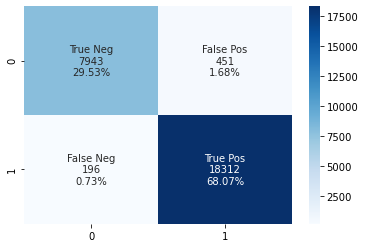

In [131]:
import seaborn as sb
cf_matrix_test = metrics.confusion_matrix(y_test, y_pred_logreg)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sb.heatmap(cf_matrix_test, annot=labels, fmt='', cmap='Blues')

In [132]:
clf = logreg1


feature_names = vect.get_feature_names()
coefs_with_fns_lg1 = zip(feature_names, clf.coef_[0])

coefs_with_fns_df_lg1 = pd.DataFrame(coefs_with_fns_lg1,
                    columns=['feature', 'coefficient'])
coefs_with_fns_df_lg1.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df_lg1.head(10)

,feature,coefficient
16769,pickled,2.668671
6637,details,2.429322
3195,canvass,2.173605
4520,codes,2.162997
20089,safety,2.159800
18986,remaining,2.061545
24287,typing,1.919625
23099,tcs,1.911495
17086,policies,1.897654
18980,remain,1.836698


### Logistic Regression - result with ngram

In [113]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_dtm, y_train)

LogisticRegression(max_iter=10000)

In [114]:
# make class predictions for X_test_dtm
y_pred_logreg= logreg.predict(X_test_dtm)

In [115]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_logreg) * 100:.1f}%")
# calculate precision and recall
print(classification_report(y_test, y_pred_logreg))

Test Accuracy: 97.9%
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      8394
           1       0.98      0.99      0.98     18508

    accuracy                           0.98     26902
   macro avg       0.98      0.97      0.98     26902
weighted avg       0.98      0.98      0.98     26902



<AxesSubplot:>

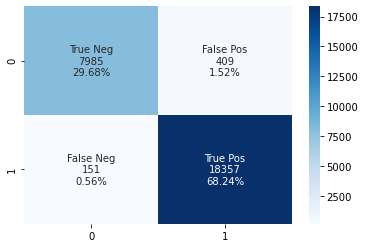

In [116]:
import seaborn as sb
cf_matrix_test = metrics.confusion_matrix(y_test, y_pred_logreg)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sb.heatmap(cf_matrix_test, annot=labels, fmt='', cmap='Blues')

In [117]:
clf = logreg


feature_names = countvectorizer.get_feature_names()
coefs_with_fns_lg = zip(feature_names, clf.coef_[0])

coefs_with_fns_df_lg = pd.DataFrame(coefs_with_fns_lg,
                    columns=['feature', 'coefficient'])
coefs_with_fns_df_lg.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df_lg.head(10)

,feature,coefficient
1965125,violation remaining,2.431427
1960316,violation corrected,2.284865
1965196,violation remains,2.009611
1964420,violation pending,1.845533
1965483,violation report,1.807433
459498,dated comply,1.590603
1507415,report violation,1.515234
114,abated,1.418849
397979,core violation,1.417445
459502,dated comply violations,1.396103


### Decision Tree - result without ngram

In [ ]:
dt1 = DecisionTreeClassifier(random_state=1123)
dt1.fit(X_train_dtm1, y_train)

In [98]:
# make class predictions for X_test_dtm
y_pred_dt = dt.predict(X_test_dtm1)

In [99]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_dt) * 100:.1f}%")
# calculate precision and recall
print(classification_report(y_test, y_pred_dt))

Test Accuracy: 96.5%
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8394
           1       0.97      0.97      0.97     18508

    accuracy                           0.96     26902
   macro avg       0.96      0.96      0.96     26902
weighted avg       0.96      0.96      0.96     26902



<AxesSubplot:>

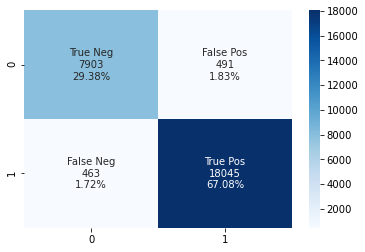

In [100]:
cf_matrix_test = metrics.confusion_matrix(y_test, y_pred_dt)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sb.heatmap(cf_matrix_test, annot=labels, fmt='', cmap='Blues')

In [104]:
clf = dt1


feature_names = vect.get_feature_names()
coefs_with_fns_dt1 = zip(feature_names, clf.feature_importances_)

coefs_with_fns_df_dt1 = pd.DataFrame(coefs_with_fns_dt1,
                    columns=['feature', 'coefficient'])
coefs_with_fns_df_dt1.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df_dt1.head(10)

,feature,coefficient
25219,violation,0.460341
4068,citation,0.213071
5297,control,0.100026
17716,priority,0.022033
18986,remaining,0.008620
4520,codes,0.008014
5336,convenient,0.006925
16573,pending,0.006813
19776,rodent,0.006181
5880,critical,0.004535


### Decision Tree - result with ngram

In [118]:
dt = DecisionTreeClassifier(random_state=1123)
dt.fit(X_train_dtm, y_train)

DecisionTreeClassifier(random_state=1123)

In [119]:
# make class predictions for X_test_dtm
y_pred_dt = dt.predict(X_test_dtm)

In [120]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_dt) * 100:.1f}%")
# calculate precision and recall
print(classification_report(y_test, y_pred_dt))

Test Accuracy: 97.0%
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8394
           1       0.98      0.98      0.98     18508

    accuracy                           0.97     26902
   macro avg       0.97      0.96      0.97     26902
weighted avg       0.97      0.97      0.97     26902



<AxesSubplot:>

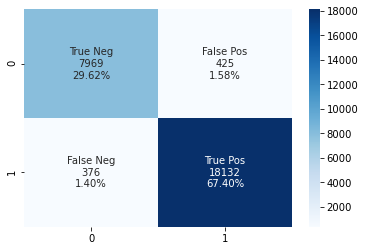

In [121]:
cf_matrix_test = metrics.confusion_matrix(y_test, y_pred_dt)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sb.heatmap(cf_matrix_test, annot=labels, fmt='', cmap='Blues')

In [122]:
clf = dt


feature_names = countvectorizer.get_feature_names()
coefs_with_fns_dt = zip(feature_names, dt.feature_importances_)

coefs_with_fns_df_dt = pd.DataFrame(coefs_with_fns_dt,
                    columns=['feature', 'coefficient'])
coefs_with_fns_df_dt.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df_dt.head(10)

,feature,coefficient
1959245,violation,0.460157
253568,citation,0.212562
359720,control,0.099273
1366741,priority,0.020242
1960101,violation codes inspector,0.009113
1965125,violation remaining,0.009005
1622741,shall adequate,0.007726
1964420,violation pending,0.006858
1533597,rodent proof,0.006121
290780,cleaning pest control,0.004630


## 4. Visualize results of at least two text classifiers and select the most robust one

### 4.1 Logistic Regression Result - without ngram

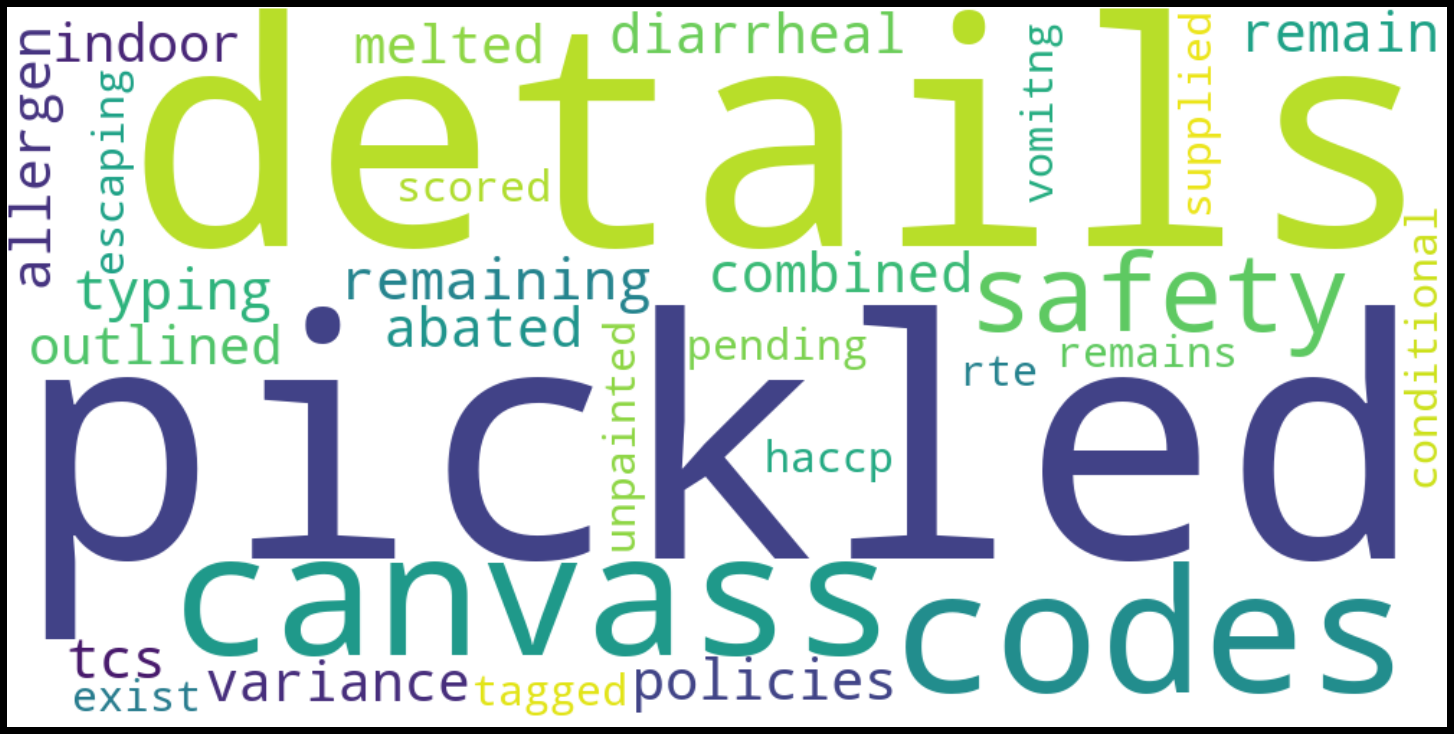

In [108]:
top_features_df_lg1 = coefs_with_fns_df_lg1.copy()
top_features_df_lg1 ['coefficient'] = top_features_df_lg1 ['coefficient']*(10)

data = dict(zip(top_features_df_lg1 ['feature'].tolist(), top_features_df_lg1 ['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

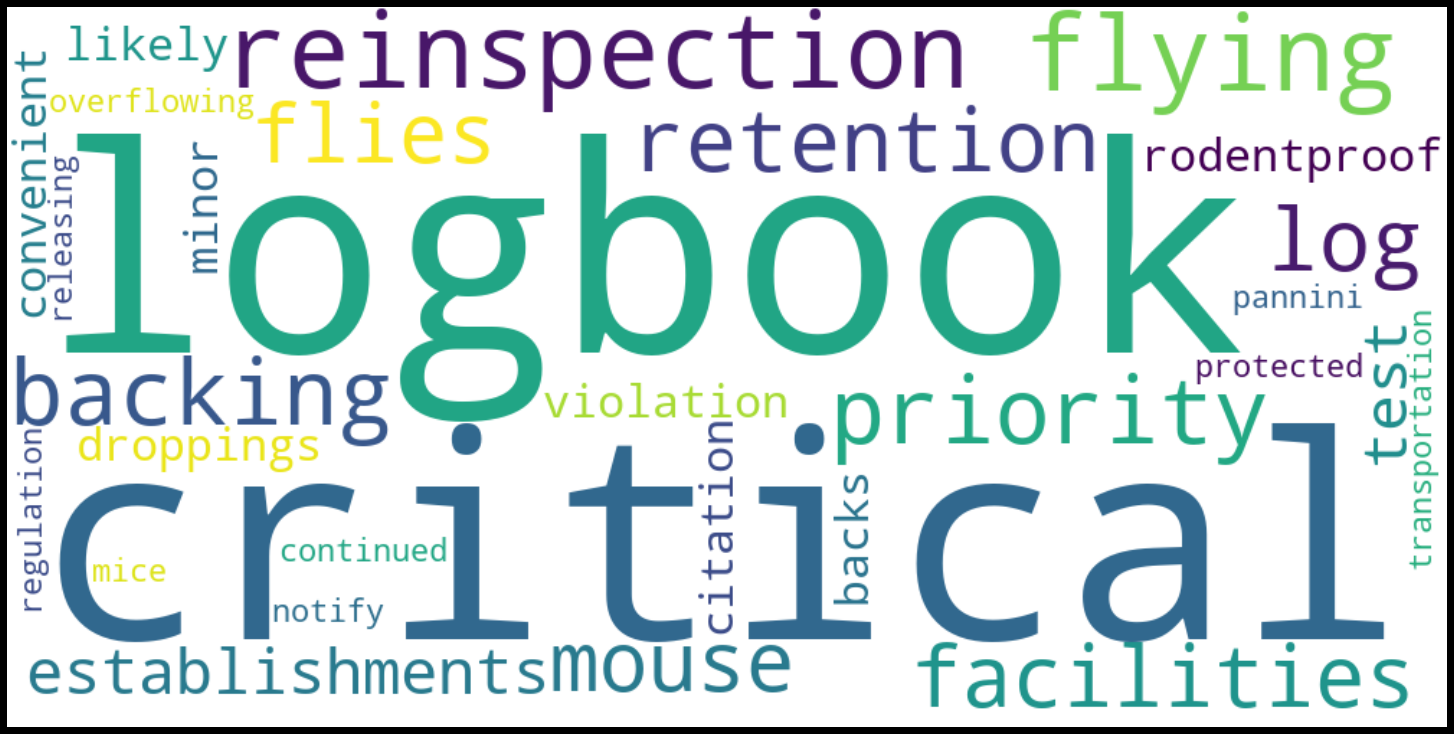

In [133]:
top_features_df_lg1 = coefs_with_fns_df_lg1.copy()
top_features_df_lg1 ['coefficient'] = top_features_df_lg1 ['coefficient']*(-10)

data = dict(zip(top_features_df_lg1 ['feature'].tolist(), top_features_df_lg1 ['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 4.2 Logistic Regression Result - with ngram

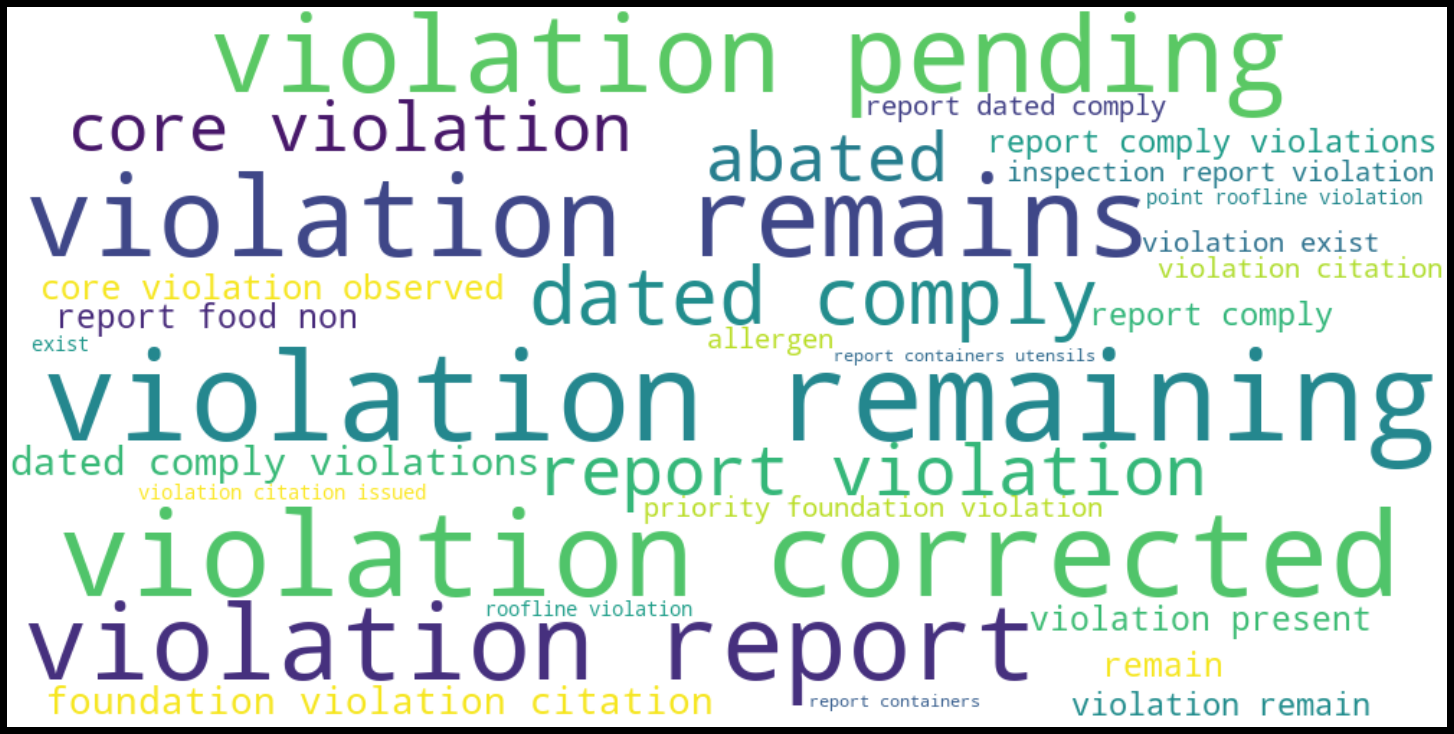

In [123]:
top_features_df_lg = coefs_with_fns_df_lg.copy()
top_features_df_lg ['coefficient'] = top_features_df_lg ['coefficient']*(10)

data = dict(zip(top_features_df_lg ['feature'].tolist(), top_features_df_lg ['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

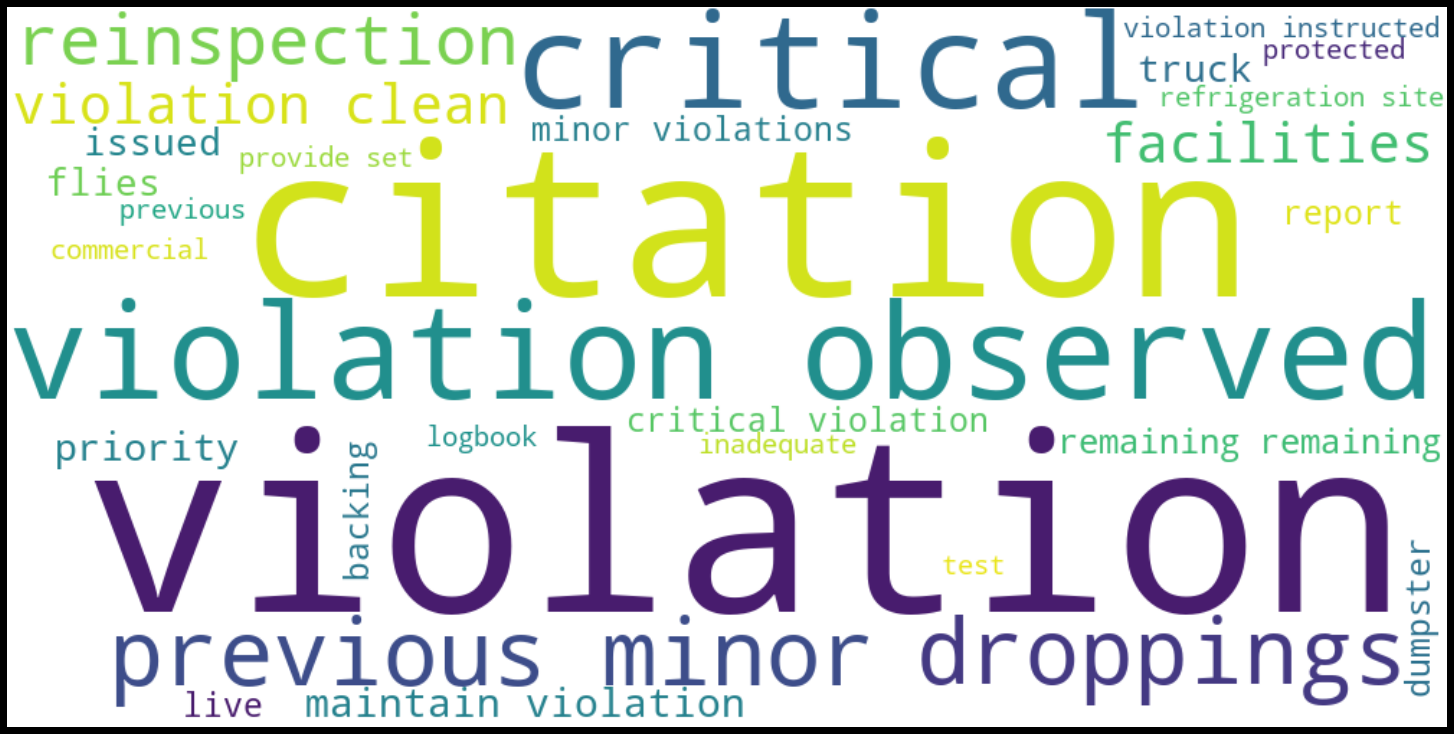

In [134]:
top_features_df_lg = coefs_with_fns_df_lg.copy()
top_features_df_lg ['coefficient'] = top_features_df_lg ['coefficient']*(-10)

data = dict(zip(top_features_df_lg ['feature'].tolist(), top_features_df_lg ['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 4.3 Decision Tree Result - without ngram

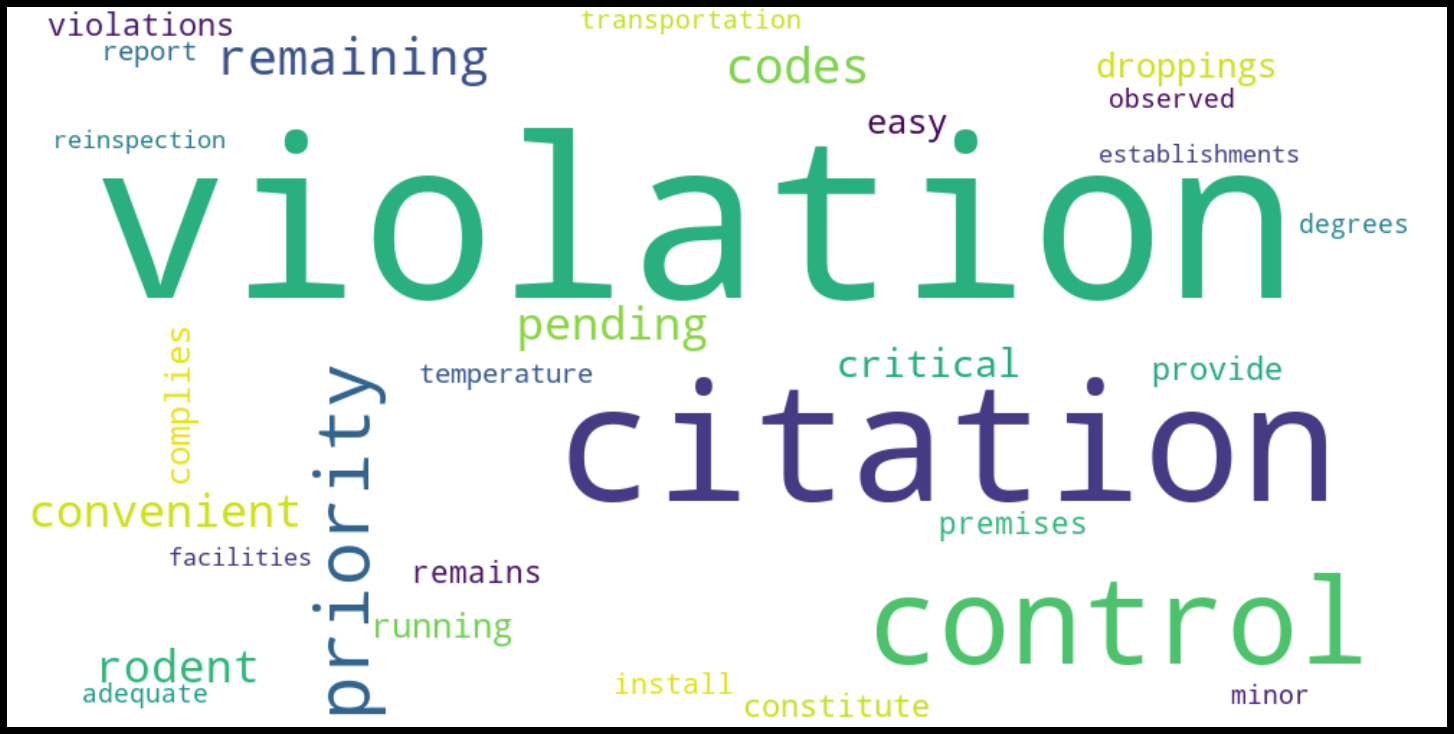

In [109]:
top_features_df_dt1 = coefs_with_fns_df_dt1.copy()
top_features_df_dt1 ['coefficient'] = top_features_df_dt1 ['coefficient']*(10)

data = dict(zip(top_features_df_dt1 ['feature'].tolist(), top_features_df_dt1 ['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 4.4 Decision Tree Result - with ngram

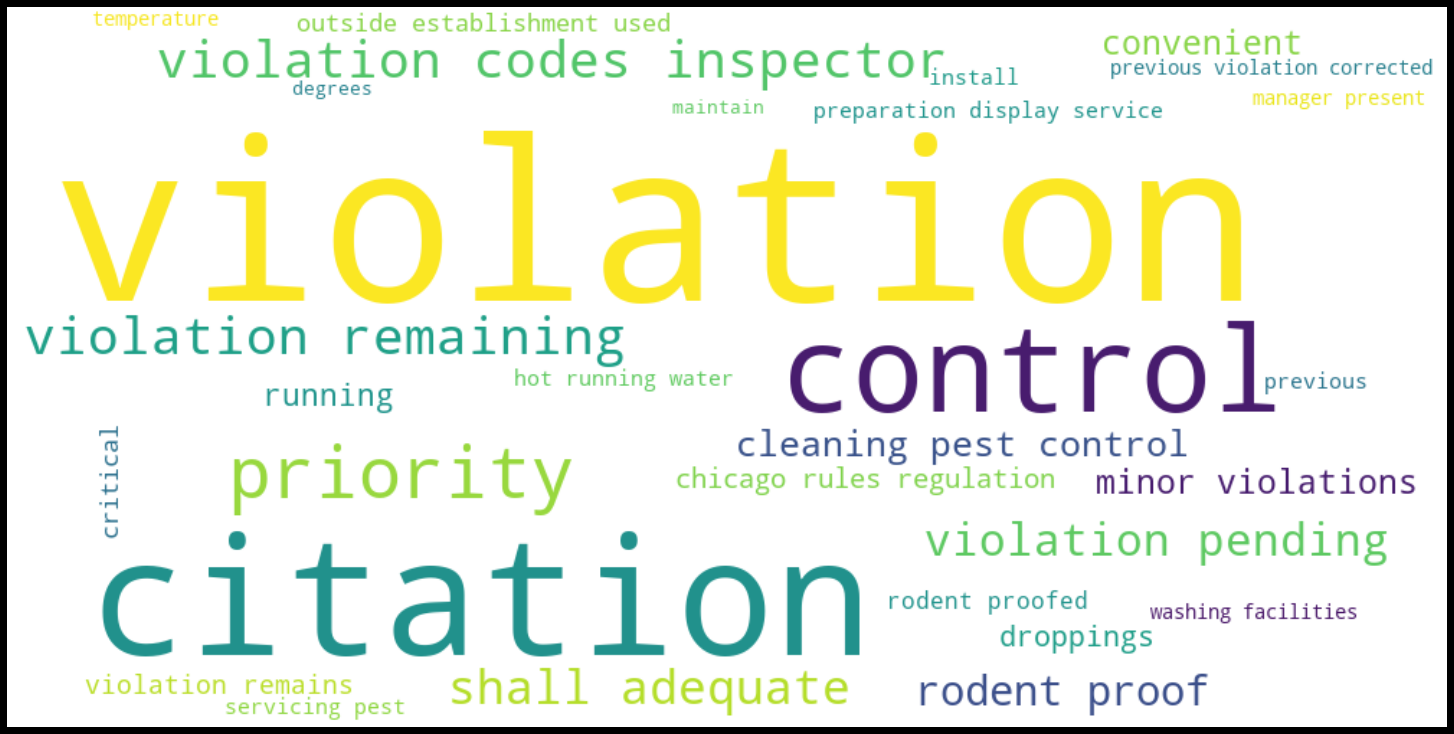

In [124]:
top_features_df_dt = coefs_with_fns_df_dt.copy()
top_features_df_dt ['coefficient'] = top_features_df_dt ['coefficient']*(10)

data = dict(zip(top_features_df_dt ['feature'].tolist(), top_features_df_dt ['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 5. Model Comparison & Selection


- Accuracy for Logistic Regression without ngram: 97.6%
- Accuracy for Logistic Regression with ngram: 97.9%
- Accuracy for DecisionTree Classifier without ngram: 96.5%
- Accuracy for DecisionTree Classifier with ngram: 97.0%

**First we could see that by incorporating ngram in the vectorizer, the overall accuracy increases for both models.**

**Then, we could see that the overall accuracy for Logistic Regression is slightly higher, with a higher precision, recall and f1-score as well. And with the ngram, the Logistic Regression model would use a much shorter time to fit comparing to that of decision tree.**

**By looking at the words with high importance/coefficient, both of the models actually give a list of reasonable words that indicate the possible violation condition. But Logistic Regression model with a CountVectorizer using ngram gives some word pairs that make more sense and more related to the pass/fail result.**

**Based on the above analysis, I would choose the Logistic Regression Model with a CountVectorizer using ngram for binary classification.**
